In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!pip install pydot
!rm -rf ./logs/ 

# Regression with Keras

So far we have mainly looked at the digits dataset, which is a classification problem with *Keras*, however it is also easy to create a regression model, we simply change the output to a single `tf.keras.layers.Dense` layer with one unit and no activation function. This outputs a scalar value that is unbounded, and is the sum of the weighted inputs from the previous layer.

I.e. a model of the form

In [2]:
from tensorflow import keras


def new_model():
    units = 32
    model = keras.Sequential([
        keras.layers.Dense(units, activation='relu', input_shape=[13]),
        keras.layers.Dense(units, activation='relu'),
        keras.layers.Dense(1)
    ])

    # Compile the regression model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model


model = new_model()

We can train such a model on a the boston housing dataset, i.e. the 

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.boston_housing.load_data()

In [4]:
epochs = 1201

# Train the regression model
history = model.fit(X_train, y_train, epochs=epochs,
                    verbose=0, validation_split=0.2)

We can visualise the models training metrics over each epoch by the attributes of the `history` object

In [5]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,1347.100013,32.473320,1347.099976,1131.290852,29.358459,1131.290894,0
1,921.413608,26.181223,921.413574,818.863074,25.132030,818.863037,1
2,695.241677,23.009254,695.241638,624.310401,22.050657,624.310364,2
3,540.401365,20.283703,540.401428,509.507575,19.618692,509.507568,3
4,438.193751,17.897213,438.193726,398.142117,16.955750,398.142120,4
...,...,...,...,...,...,...,...
1196,22.761874,3.275796,22.761873,35.091436,4.039326,35.091434,1196
1197,23.087253,3.427525,23.087254,35.168438,4.024590,35.168438,1197
1198,22.682323,3.348975,22.682323,34.992245,4.241150,34.992245,1198
1199,22.477301,3.341284,22.477303,36.450656,4.572299,36.450653,1199


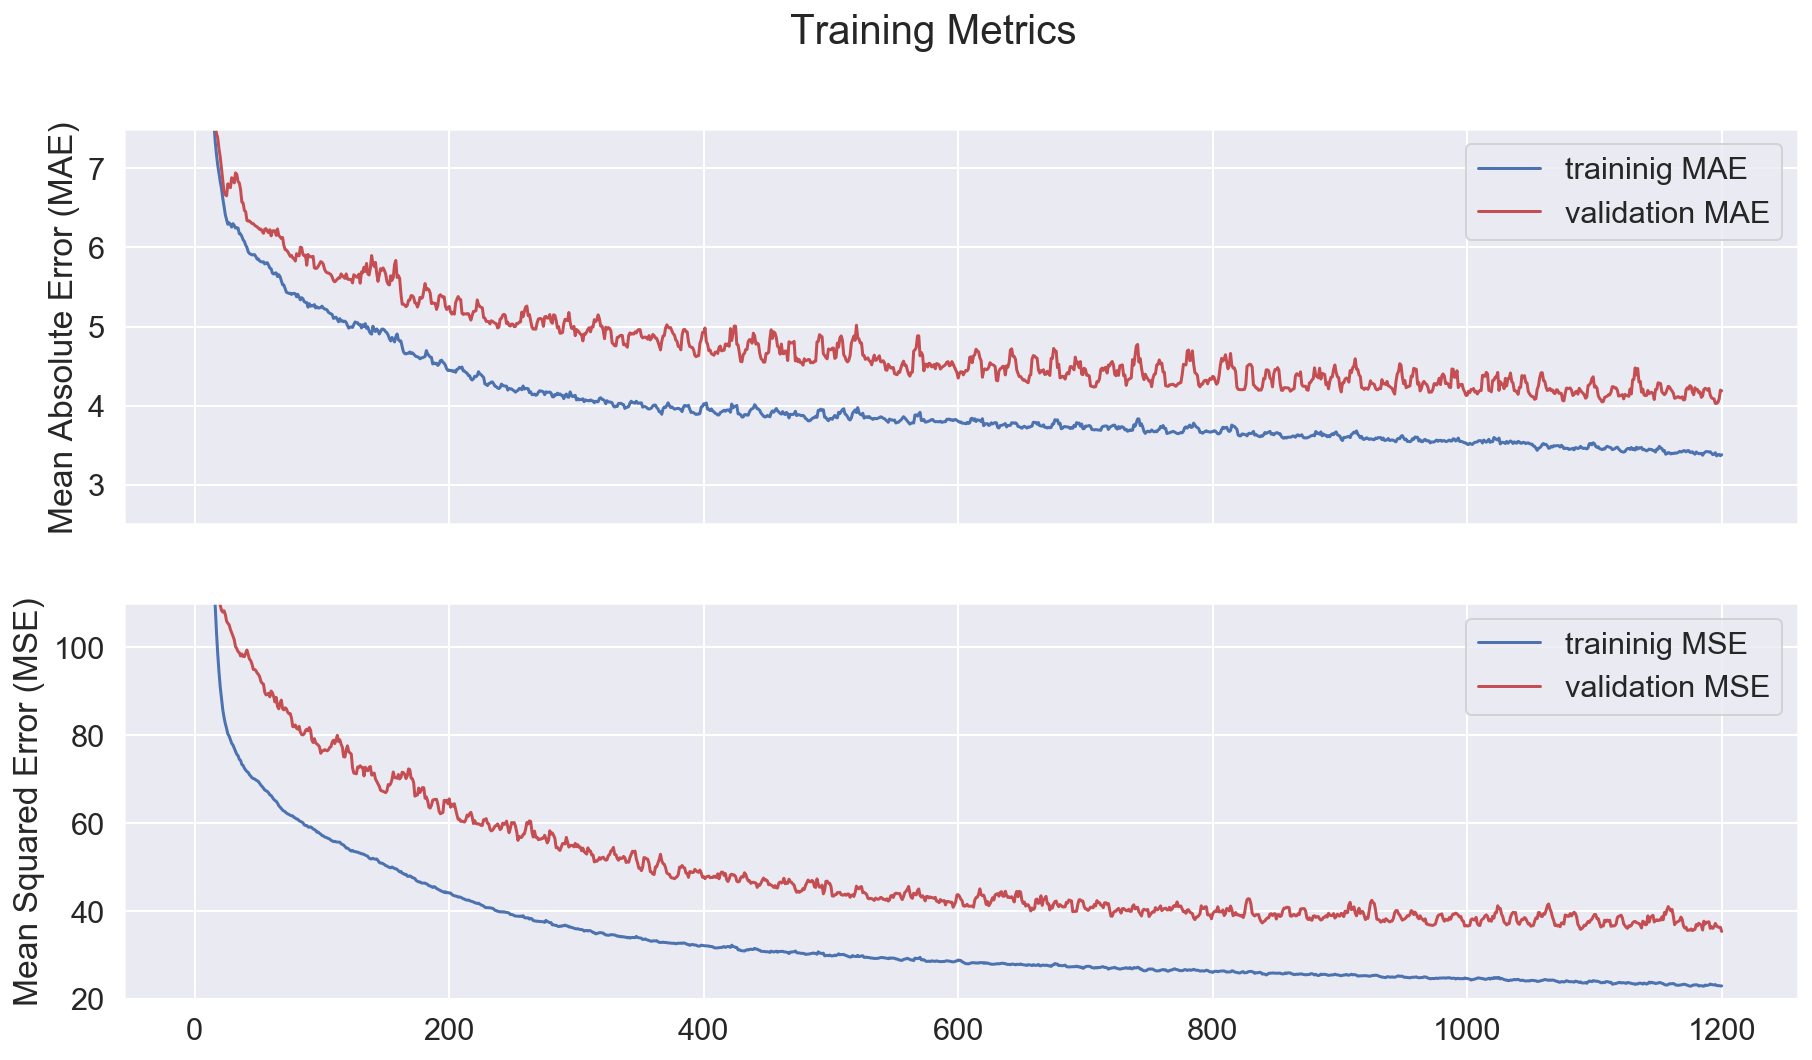

In [6]:
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 5

axes[0].set_ylabel("Mean Absolute Error (MAE)")
axes[0].plot(history_df['mae'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_mae'].rolling(epochs_to_mean).mean(), '-r')
axes[0].set_ylim(2.5, 7.5)
axes[0].legend(['traininig MAE', 'validation MAE'])

axes[1].set_ylabel("Mean Squared Error (MSE)")
axes[1].plot(history_df['mse'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_mse'].rolling(epochs_to_mean).mean(), '-r')
axes[1].set_ylim(20, 110)
axes[1].legend(['traininig MSE', 'validation MSE'])
plt.show()

The plot above shows that that the losses plateau quickly, and that after about 400 epochs the validation mean squared error loss is not reducing. To optomise training, we can use the *EarlyStopping* callback, and set it so that if there is no reductio in the validation MSE after a set amount of epochs we can automatically stop training.

In [7]:
model = new_model()

# Here the patience parameter is the amount of epochs to check for reduction in the validation error
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(X_train, y_train,
                          epochs=epochs, validation_split=0.2, verbose=0,
                          callbacks=[early_stop])

In [8]:
history_df = pd.DataFrame(early_history.history)
history_df['epoch'] = early_history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,4182.573563,58.484169,4182.573730,3189.007897,49.835793,3189.007812,0
1,3214.165642,50.470612,3214.165771,2458.449008,42.814610,2458.448975,1
2,2520.565534,43.976860,2520.565674,1909.467584,36.768372,1909.467651,2
3,1979.904744,38.188850,1979.904785,1505.412806,31.760799,1505.412842,3
4,1564.399388,33.120342,1564.399414,1136.378846,26.698492,1136.378906,4
...,...,...,...,...,...,...,...
124,54.133641,5.164279,54.133648,69.342101,5.343847,69.342102,124
125,54.420048,5.132810,54.420048,69.874840,5.324442,69.874840,125
126,54.047691,5.134604,54.047699,73.821940,5.389747,73.821938,126
127,54.326845,5.090065,54.326851,70.543688,5.316560,70.543686,127


We can see that it stopped at about epoch before our defined number of epochs, saving computation and resources, plotting the losses from the training below

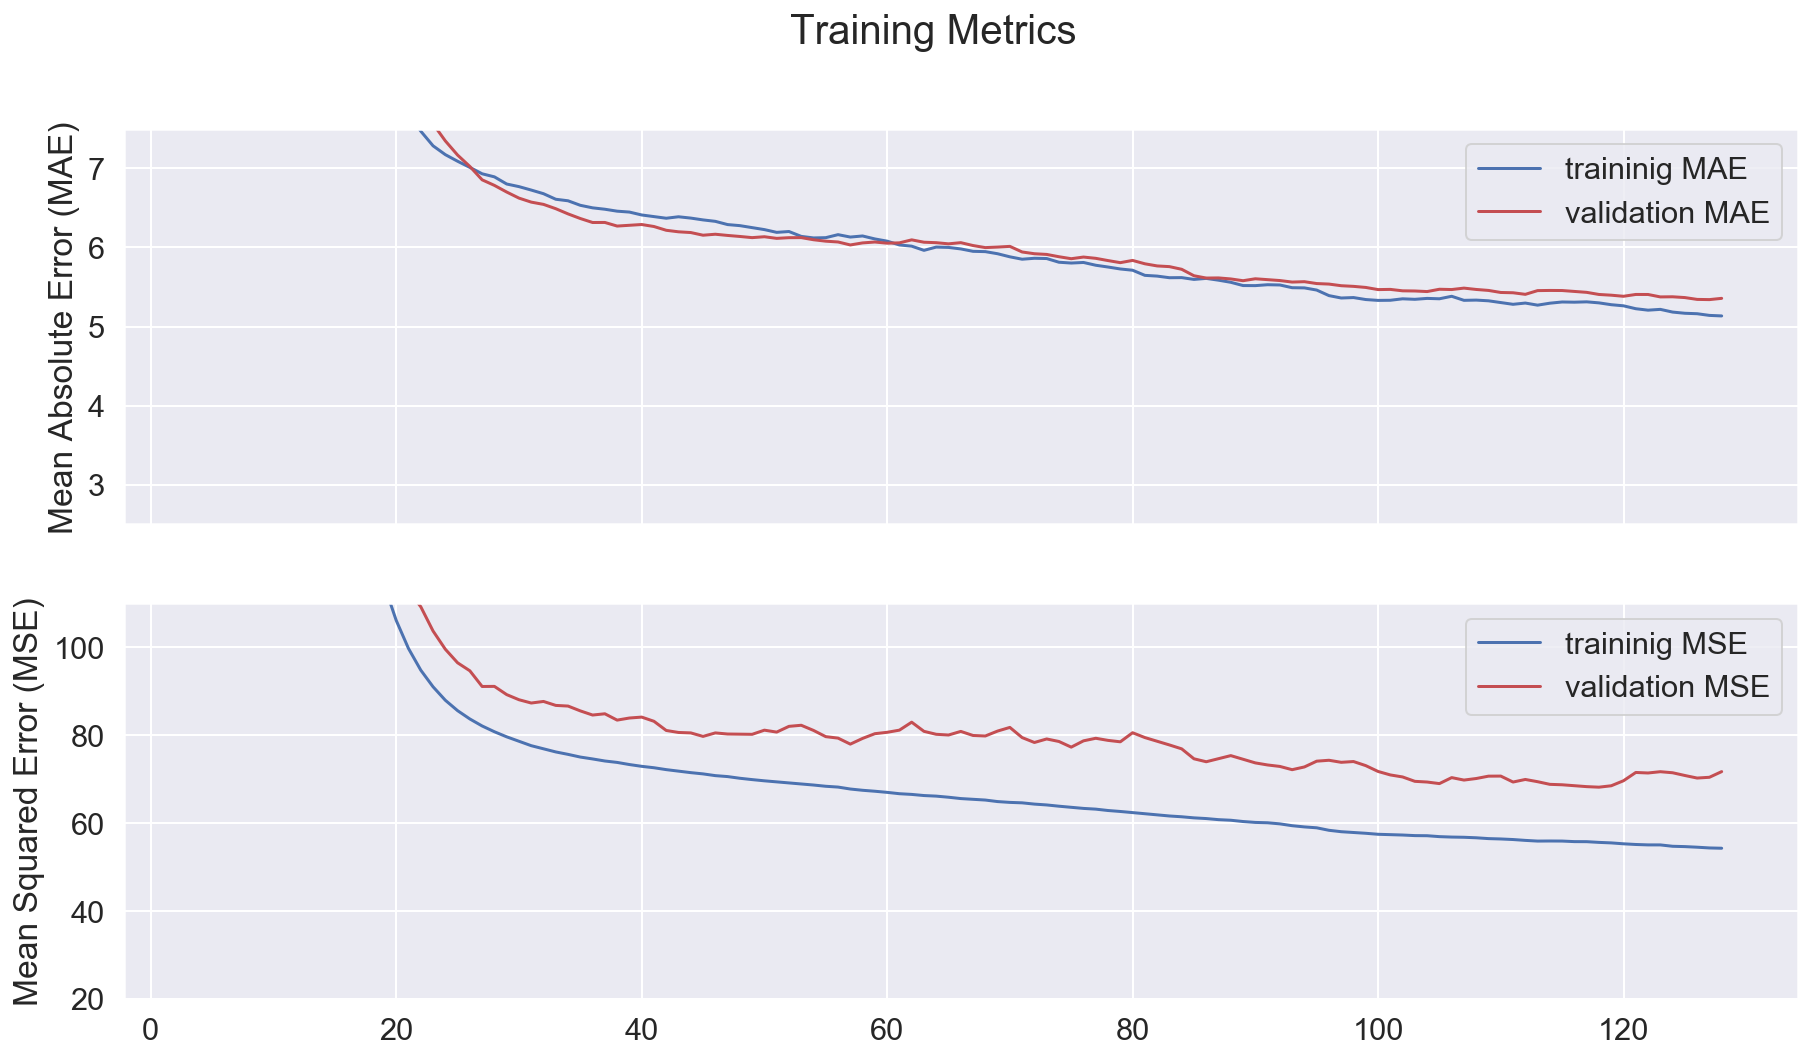

In [9]:
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 5

axes[0].set_ylabel("Mean Absolute Error (MAE)")
axes[0].plot(history_df['mae'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_mae'].rolling(epochs_to_mean).mean(), '-r')
axes[0].set_ylim(2.5, 7.5)
axes[0].legend(['traininig MAE', 'validation MAE'])

axes[1].set_ylabel("Mean Squared Error (MSE)")
axes[1].plot(history_df['mse'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_mse'].rolling(epochs_to_mean).mean(), '-r')
axes[1].set_ylim(20, 110)
axes[1].legend(['traininig MSE', 'validation MSE'])
plt.show()

We can evaluate the model on the test set as well

In [10]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)
print("Test Mean Absolute Error: {:5.2f} in $1000's".format(mae))

102/102 - 0s - loss: 70.2323 - mae: 6.2206 - mse: 70.2324
Test Mean Absolute Error:  6.22 in $1000's


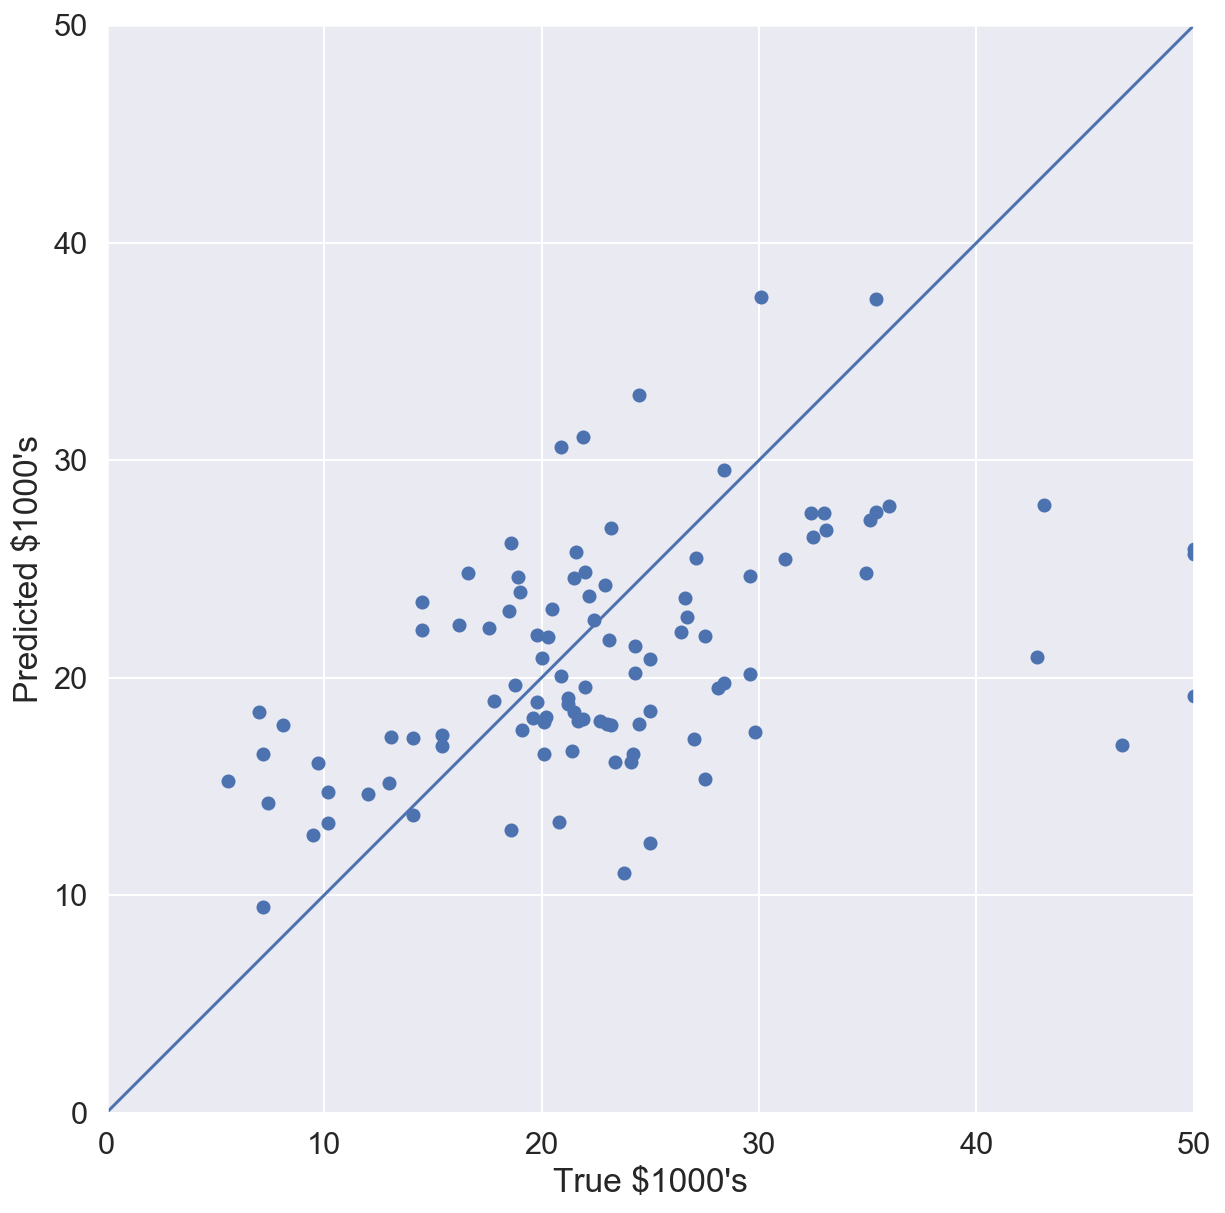

In [11]:
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(10,10))
plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel("True $1000's")
plt.ylabel("Predicted $1000's")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.show()

Our model predicts suitable as a first pass. 

We can look our error distribution of the predicted against test output values

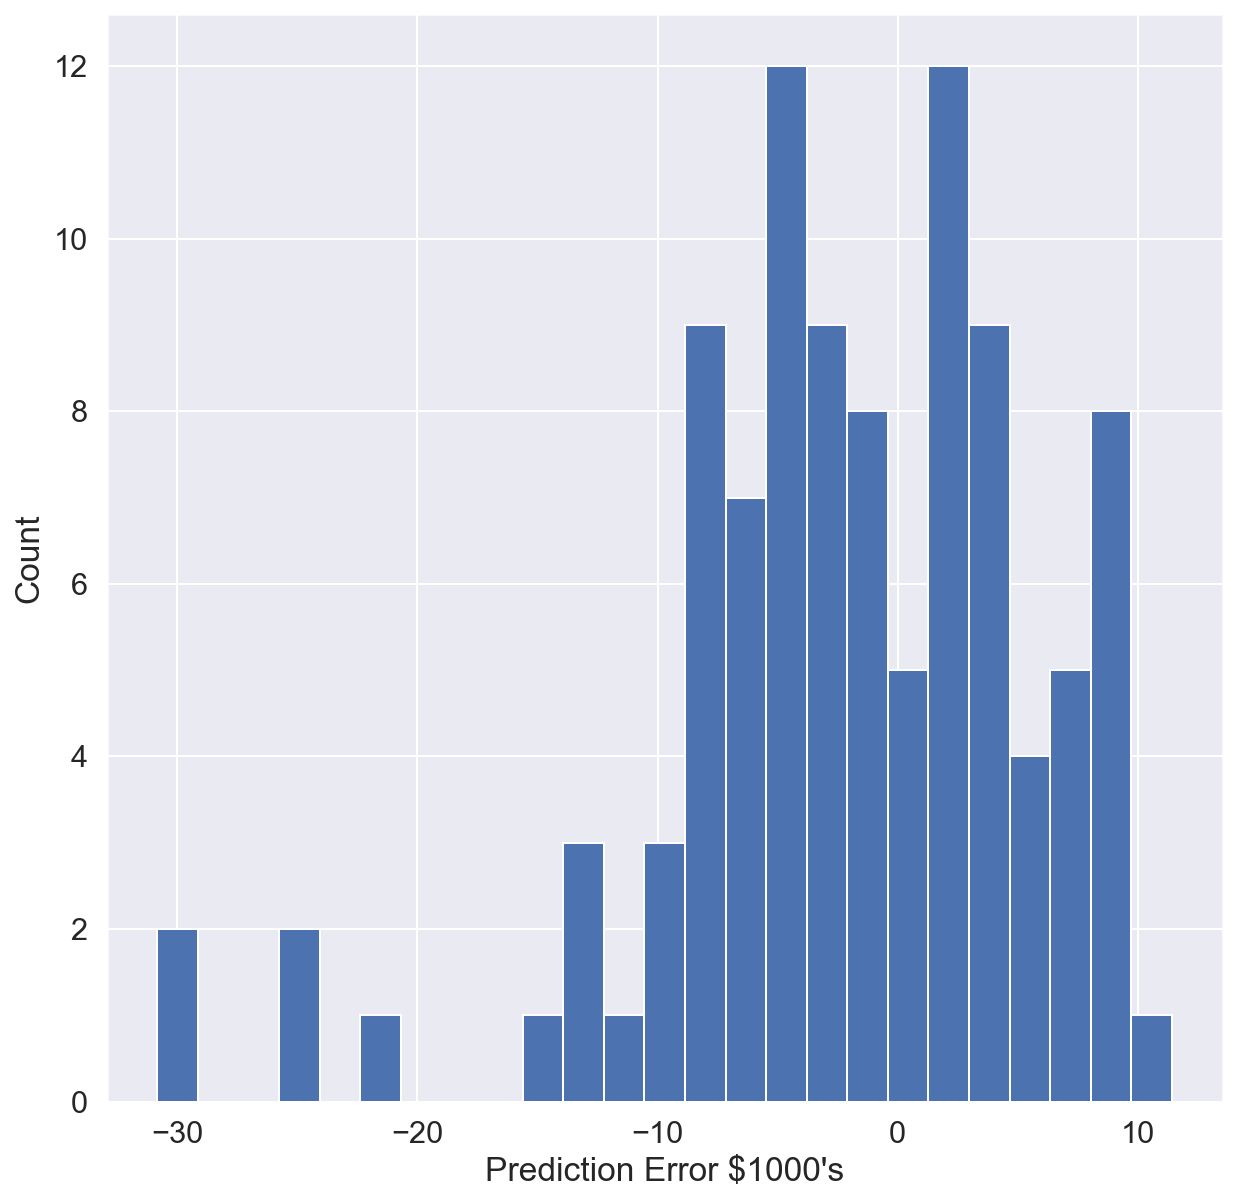

In [12]:
error = y_pred - y_test
plt.figure(figsize=(10,10))
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error $1000's")
plt.ylabel("Count")
plt.show()

The error distribution shows approximate gaussian shape around zero, however with some large errors where the model couldn't predict the larger values

# Core Neural Network Concepts

Recall from previous sections (Video 3-1) for supervised learning we are trying to find the general function that maps the input to the output, i.e. $y=f(X)$. We can learn an approximation for this function by training the parameters of the model on the training data set $(X_{train}, y_{train})$, and then evaluating them on the test set. To fit sufficiently to the training set we want a model that has enough complexity, hence enough parameters to approximate this function. 

For neural networks there are a few parameters to set initially

## Amount of units (neurons)

For a general neural network, with fully connected dense layers in pratice a 3 layer neural network is best to start with, however increasing the layers (4,5,6) rarely helps much more. The number of units per layer that is a good starting point is 3 times in the input feature dimension of the sample.

However if the *generalised* function we are trying to learn has high complexity (i.e. language understanding) increasing the models parameters will increase the models capacity to model that complexity. Also some architectures benefit from many hidden layers, such as convolutional neural network layers. Having more hidden layers allows more hierarichal features to be learnt.

One way to check if a model has enough complexity to model the function we are trying to learn, is to see if by increasing the number of parameters (units per layer or the number of hidden layers) we get diminishing returns in a reduction of our traininig loss metric.

Diagram below shows increasing the number of units (for a single layer neural network) increases the models complexity to sufficiently model the problem (e.g. binary classification in 2D).

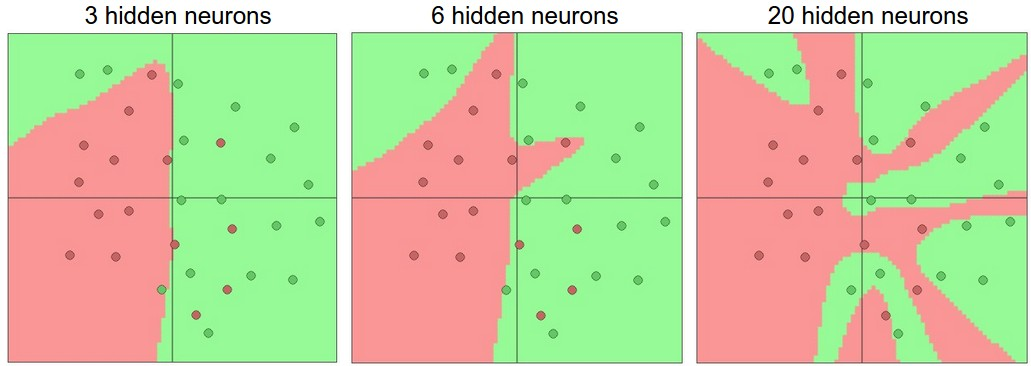


## Methods to prevent overfitting

In neural networks there are multiple methods to prevent overfitting, and a complex model will easily overfit to the training dataset given enough complexity. If we can get the same validation or test accuracy with a simpler model we favour the simpler model, as it ideally makes less probabilistic assumptions about the data (allowing it to generalise better).

### Reguarlisation

To learn a *generalisable* model and not overfit to the training set, we penalise the parameters in the loss function. This learns reduced weight parameters. There are several ways of doing this (passing one of the following keyword arguments to layers that support regularisation, i.e. `tf.keras.layers.Dense`):

> $L_2$ regularisation
> $$ J(w) + \frac{1}{2} \lambda \|w\|_2$$
> `kernel_regularizer=tf.keras.regularizers.l1(`$\lambda$`)`

> $L_1$ regularisation
> $$ J(w) + \lambda \|w\|_1$$
> `kernel_regularizer=tf.keras.regularizers.l2(`$\lambda$`)`

> Elastic net regularisation
> $$ J(w) + \lambda_1 \|w\|_1 + \lambda_2 \|w\|_2$$
> `kernel_regularizer=tf.keras.regularizers.l1_l2(`$\lambda_1, \lambda_2$`)`

$L_2$ regularisation usually yields the best results, however $L_1$ regularistation can learn sparse weights with some set to zero (i.e. learning the most important weights). We normally apply the same regularisation to all layers in the network.

Diagram below shows, for classifcation problems makes the model learn smoother decision regions on the input space, for a complex enough model (here a 20 unit single layer neural network).

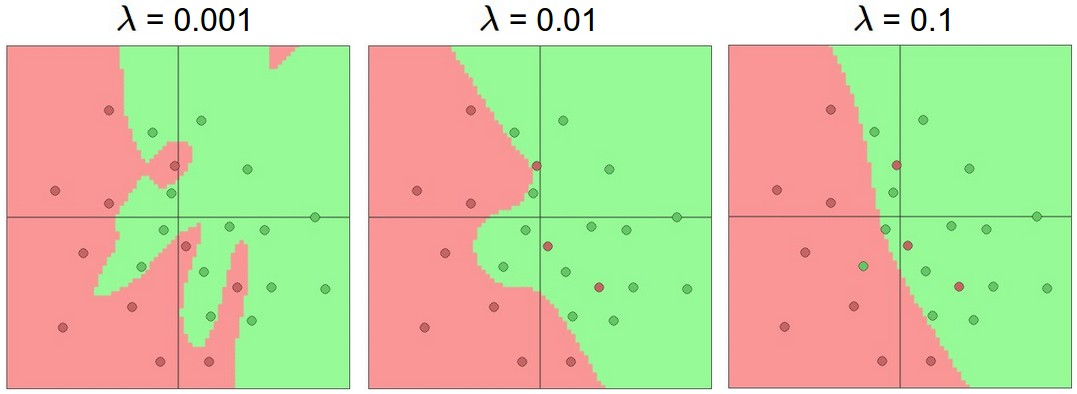

### Maxnorm

We enforce an upper bound constraint on the magnitude of the weight vector for every neuron. I.e. we update the weight parameters $w$ and enforce 

$$\|w\|_2<c$$

Typical values for $c$ are 3 or 4. This prevents the weights from *exploding* when the learning rates are set too high as the updates are always bounded. In Keras we achieve this by passing a layer the keyword argument `kernel_constraint=tf.keras.constraints.MaxNorm(`$c$`)`.

### Dropout

Dropout is an extremely effective and simple form of regularisation, which complements the other methods above. While training, dropout is implemented by only keeping each neuron active with some probability $p$, otherwise it is set to zero. During training dropout can be interpreted as sampling the neural network from the full network and only updating the paramters for that sampled network.

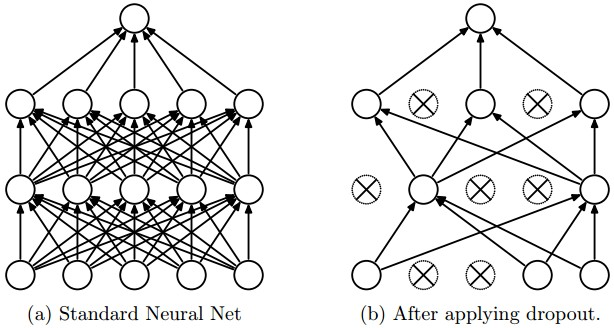

During testing there is no dropout applied, and this can be interepeted as evaluating an averaged prediction across all of the sub-networks.

Keras implements dropout as a layer that we have to put before add a layer, i.e. `tf.keras.layers.Dropout(rate)`, where `rate` is the fraction of input units to drop, between 0 and 1, good starting values are 0.2 to 0.5.

## Data pre-processing

Good to normalise the input features for a NN

## Losses

Which losses to use

## Gradient descents

Go through all gradient descent methods & how they work and which one is best in general & why


## Hyper parameter optomisation

Random search through them really


## Regularisers really before this ! 

## Optomisers !

## Normalisation techniques

## Maybe fine tuning some of the neural network parameters and discussion about these here


---

# Training deep neurla netowrks ! - Vanishing & Exploding gradients problems



# Artificial neural networks (ANN)

Will have to do a video on Tensorboard at some point

Optomizers

Activation functions

Initilisation schemes etc

Dropout etc ! 